In [1]:
 # These two lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../../../..")
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=cpu"

# Importing GemPy
import gempy as gp

# Embedding matplotlib figures in the notebooks
%matplotlib notebook

# Importing auxiliary libraries
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az

## Model definition

In the previous example we assume constant thickness to be able to reduce the problem to one dimension. This keeps the probabilistic model fairly simple since we do not need to deel with complex geometric structures. Unfortunaly, geology is all about dealing with complex three dimensional structures. In the moment data spread across the physical space, the probabilistic model will have to expand to relate data from different locations. In other words, the model will need to include either interpolations, regressions or some other sort of spatial functions. In this paper, we use an advance universal co-kriging interpolator. Further implications of using this method will be discuss below but for this lets treat is a simple spatial interpolation in order to keep the focus on the constraction of the probabilistic model.

In [19]:
geo_model = gp.create_model('2-layers')
gp.init_data(geo_model, extent=[0, 10, 0, 10, 0, 10], resolution=[100,1,100])

Active grids: ['regular']


2-layers  2019-09-11 14:15

In [28]:
500*500

250000

In [20]:
geo_model.add_surfaces('surface 1')
geo_model.add_surfaces('surface 2')
geo_model.add_surfaces('basement')

,surface,series,order_surfaces,isBasement,color,id
0,surface 1,Default series,1,False,#015482,1
1,surface 2,Default series,2,False,#9f0052,2
2,basement,Default series,3,True,#ffbe00,3


In [21]:
geo_model.add_surface_points(3, 5, 3, 'surface 1')
geo_model.add_surface_points(7, 5, 2, 'surface 1')

geo_model.add_surface_points(3, 5, 6, 'surface 2')
geo_model.add_surface_points(7, 5, 5, 'surface 2')

geo_model.add_orientations(5, 5, 50, 'surface 1', [0,0,1])

,X,Y,Z,X_r,Y_r,Z_r,G_x,G_y,G_z,dip,azimuth,polarity,surface,series,id,order_series,smooth
0,5.0,5.0,50.0,0.5001,0.5001,0.7501,0.0,0.0,1.0,0.0,0.0,1.0,surface 1,Default series,1,1,0.01


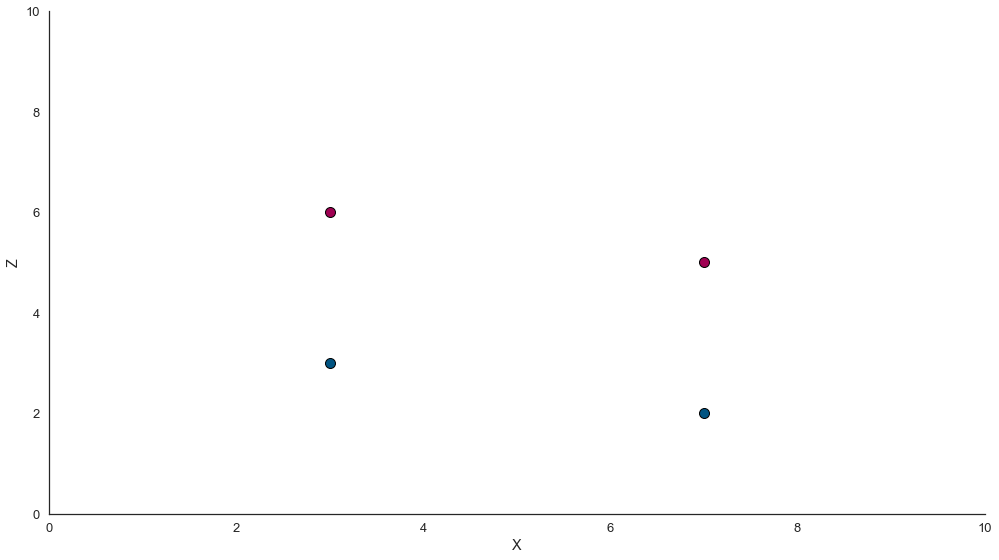

In [22]:
gp.plot.plot_data(geo_model)

In [23]:
gp.set_interpolation_data(geo_model)

Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!


In [24]:
geo_model.surface_points

,X,Y,Z,X_r,Y_r,Z_r,surface,series,id,order_series,smooth
0,3.0,5.0,3.0,0.479267,0.5001,0.260517,surface 1,Default series,1.0,1.0,1.000000e-08
1,7.0,5.0,2.0,0.520933,0.5001,0.250100,surface 1,Default series,1.0,1.0,1.000000e-08
2,3.0,5.0,6.0,0.479267,0.5001,0.291767,surface 2,Default series,2.0,1.0,1.000000e-08
3,7.0,5.0,5.0,0.520933,0.5001,0.281350,surface 2,Default series,2.0,1.0,1.000000e-08


In [25]:
gp.compute_model(geo_model, compute_mesh=True)

../../../../gempy/core/solution.py:259: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.. The surface is: Series: Input array must be at least 2x2x2.; Surface Number:0
  '; Surface Number:' + str(s_n))
../../../../gempy/core/solution.py:259: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.. The surface is: Series: Input array must be at least 2x2x2.; Surface Number:1
  '; Surface Number:' + str(s_n))



Lithology ids 
  [3. 3. 3. ... 1. 1. 1.] 

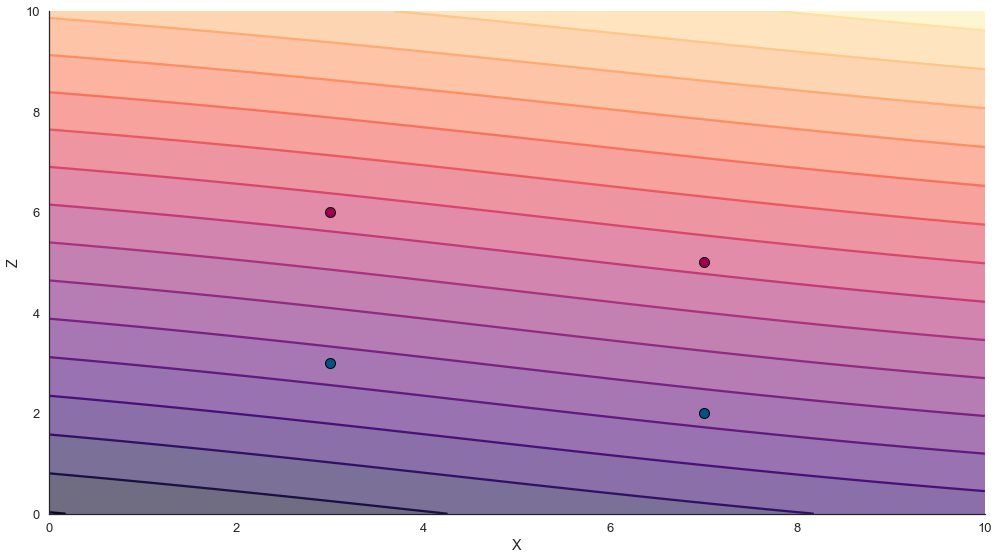

In [26]:
gp.plot.plot_scalar_field(geo_model, 0, show_all_data=True)

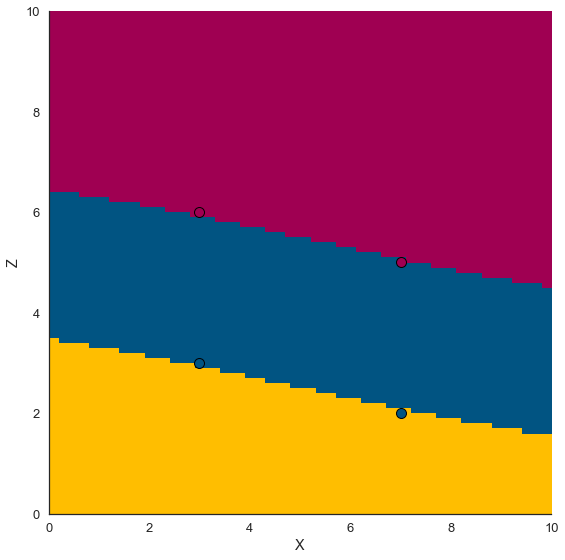

In [27]:
gp.plot.plot_section(geo_model, 0, show_all_data=True, direction='y')

In [23]:
gp.plot.plot_3D(geo_model)

closing vtk


In [2]:
with pm.Model() as model:
    r2 = pm.Normal('depth 2', -50, 5)
    r1 = pm.Normal('depth 1', -40, 5)
   
    mu = pm.Deterministic('$\mu$', r2-r1)
    sigma = pm.Gamma('$\sigma$', 1, .7)

    y = pm.Normal('y', mu=mu, sd=sigma, observed=[7, 6, 5, 6, 6, 6.2, 5, 15])


In [3]:
r2

depth 2

In [4]:
r1

depth 1

In [5]:
mu

$\mu$

In [6]:
sigma

$\sigma$

In [7]:
y

y

## Sampling

In [8]:
with model:
    prior = pm.sample_prior_predictive(1000)
    trace = pm.sample(1000)
    post = pm.sample_posterior_predictive(trace)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [$\sigma$, depth 1, depth 2]
100%|██████████| 4000/4000 [00:02<00:00, 1801.72it/s]


In [9]:
import arviz as az

data = az.from_pymc3(trace=trace,
                     prior=prior,
                     posterior_predictive=post)
data

Inference data with groups:
	> posterior
	> sample_stats
	> posterior_predictive
	> prior
	> observed_data

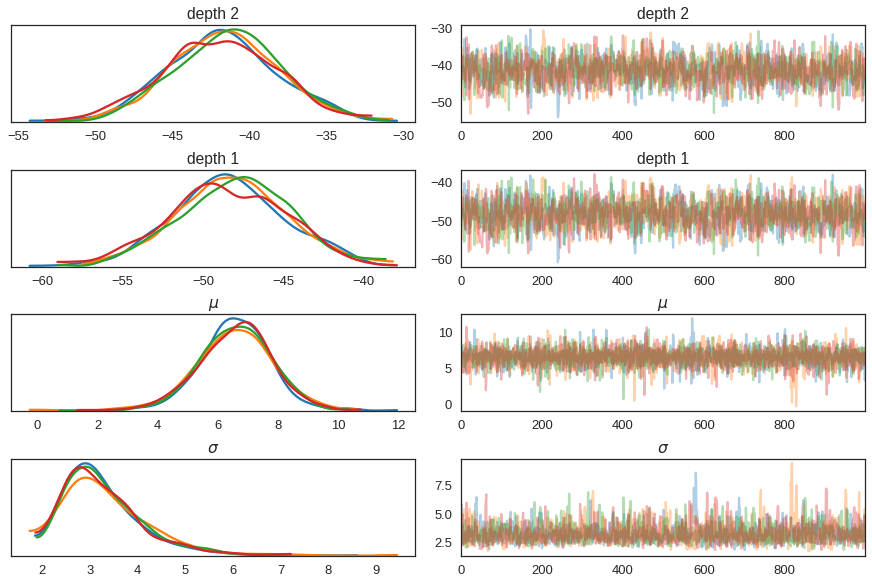

In [10]:
az.plot_trace(data);

In [11]:
# !git pull
from gempy.bayesian import plot_posterior as pp

import seaborn as sns


<IPython.core.display.Javascript object>


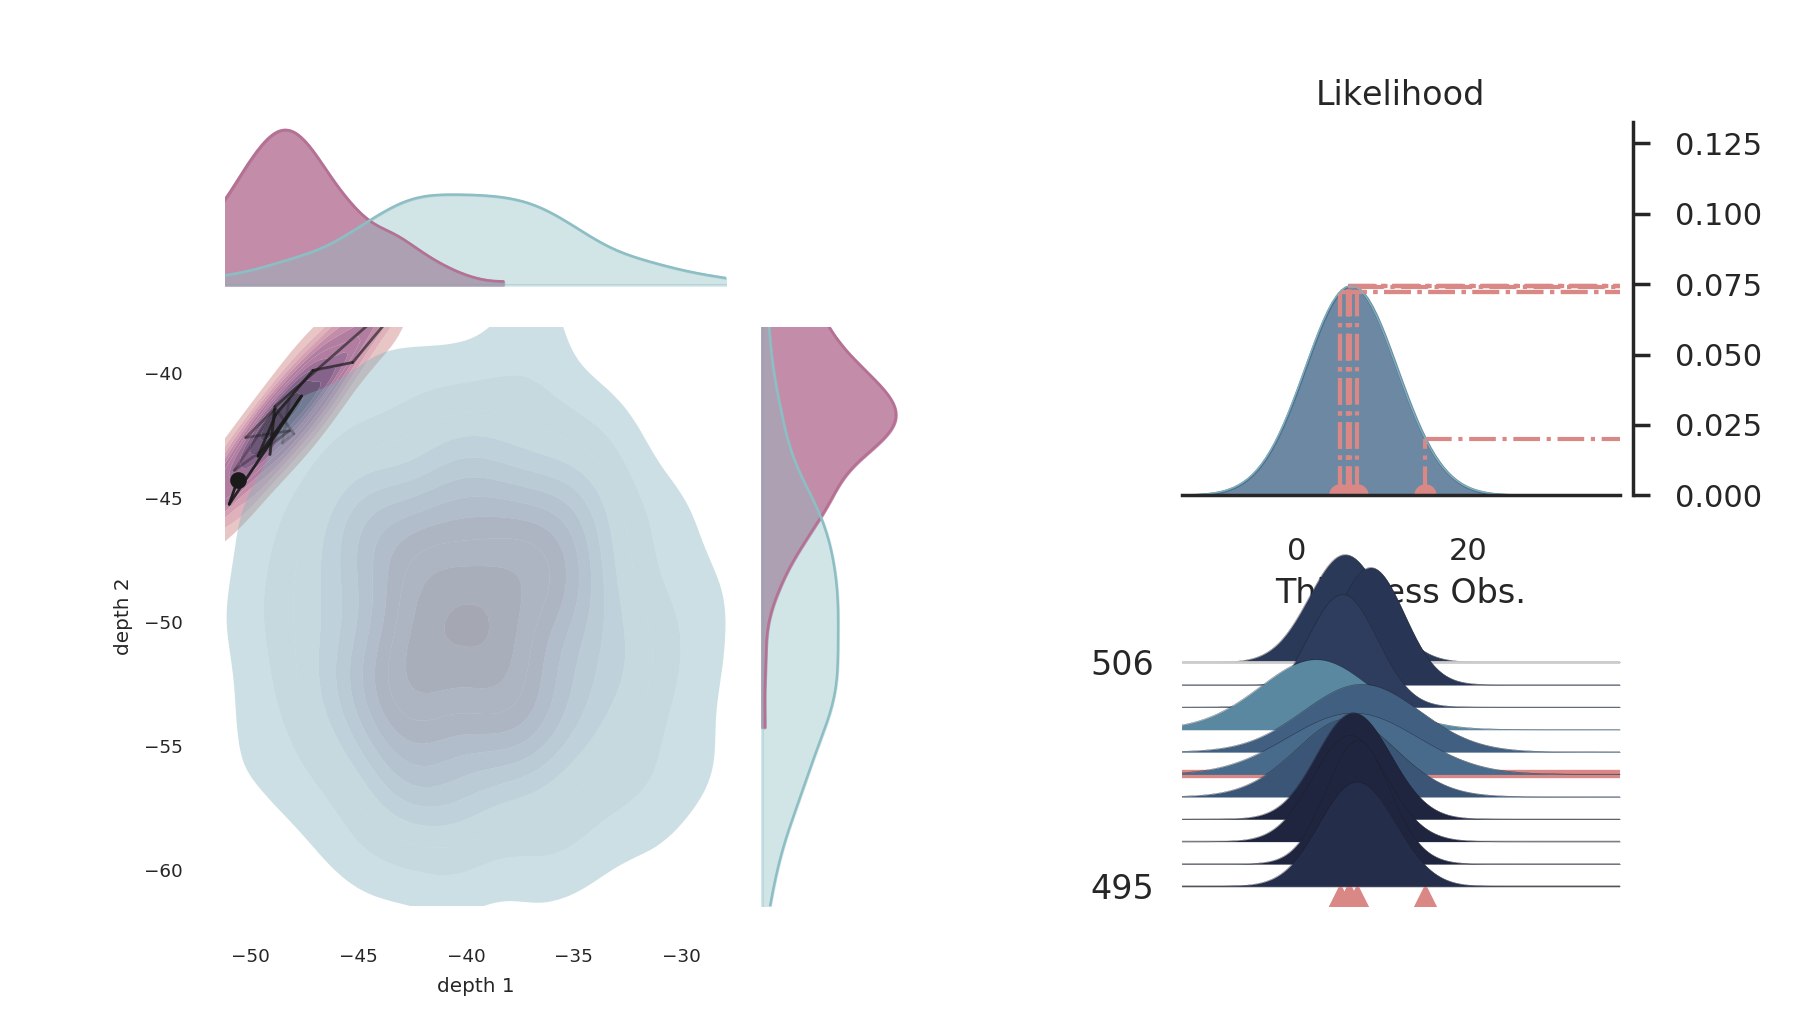

In [13]:
%matplotlib notebook
from importlib import reload
reload(pp)
p = pp.PlotPosterior(data)
p.create_figure(figsize=(9,3), joyplot=True)

In [23]:
def change_iteration(iteration):
    p.plot_posterior(['depth 1', 'depth 2'], ['$\mu$', '$\sigma$'], 'y', iteration)
    # p.plot_posterior(['$\mu$', '$\sigma$'], ['$\mu$', '$\sigma$'], 'y', iteration)

In [24]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

interact(change_iteration, iteration=(0, 1000, 1))

interactive(children=(IntSlider(value=500, description='iteration', max=1000), Output()), _dom_classes=('widge…

<function __main__.change_iteration(iteration)>

In [19]:
from gempy.bayesian.plot_posterior import my_cmap_full

<IPython.core.display.Javascript object>


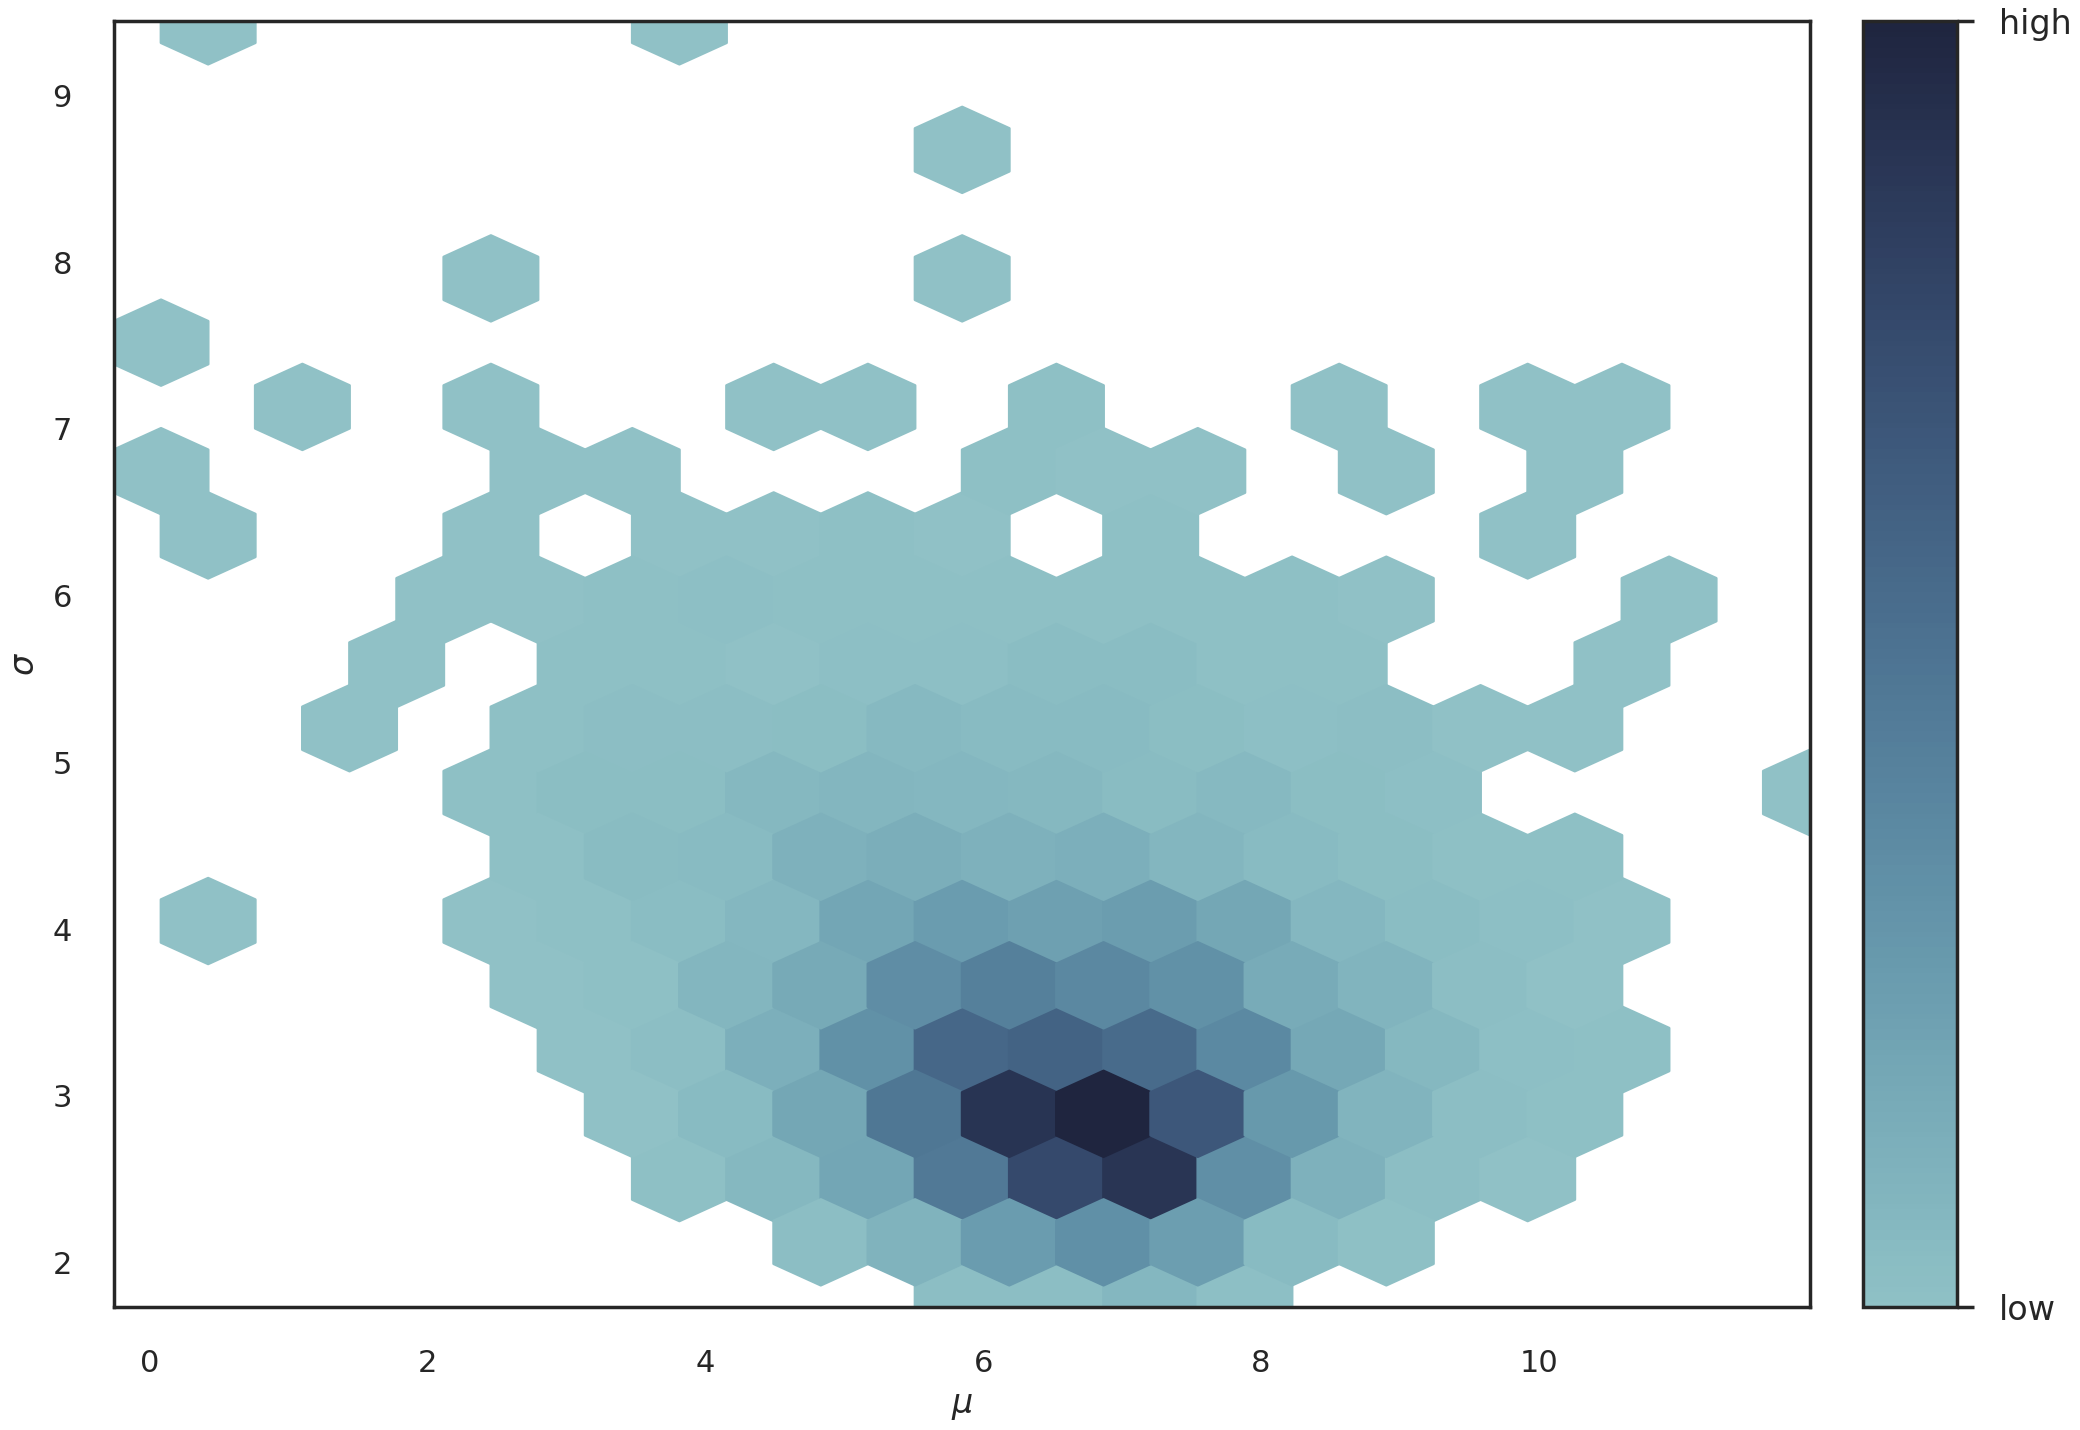

In [20]:
az.plot_pair(data, divergences=True, var_names=['$\mu$', '$\sigma$', '$y$'], kind='hexbin', contour=True,
            colorbar=True, plot_kwargs={'cmap':my_cmap_full});